In [19]:
import os
import sys

# Use the current working directory as the base
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from weaviate_rag.rag_system import GraphRAGSystem
import ollama
from ragas import evaluate
from ragas.metrics import Faithfulness, AnswerRelevancy, ContextRecall
import re
from ragas import EvaluationDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Load your JSON data
# with open('/Users/alexlecu/PycharmProjects/LLMKGraph/backend/evaluation/data/grok_evaluation_dataset_mini/True_or_False_questions_mini.json', 'r') as f:
with open('/Users/alexlecu/PycharmProjects/LLMKGraph/backend/evaluation/data/grok_evaluation_datasets/1_Hop_True_or_False_Questions.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame for analysis
df = pd.DataFrame(data)
df = df[['question', 'answer']]

# Add columns for evaluation
df['contexts'] = None  # Will be filled with retrieved passages
df['with_context_answer'] = None  # Will be filled with RAG responses
df['without_context_answer'] = None  # Will be filled with model-only responses

In [7]:
def generate_answer_with_context(question, context, model="llama3.2"):
    """Generate answer using the model with context - simplified prompt"""
    # More direct prompt focused on true/false determination
    system_prompt = f"""
    Given this medical information, determine if the statement is TRUE or FALSE.
    
    INFORMATION:
    {context}
    
    IMPORTANT: Respond with ONLY the word "True" or "False".
    """
   
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        stream=False
    )
    return response['message']['content']

In [8]:
def generate_answer_without_context(question, model="llama3.2"):
    """Generate answer using the model without context"""
    system_prompt = """
    Determine if this medical statement is TRUE or FALSE based on your knowledge.
    
    IMPORTANT: Respond with ONLY the word "True" or "False".
    """
    
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        stream=False
    )
    return response['message']['content']

In [5]:
def remove_think_tags(response):
    """Remove any thinking tags from the response"""
    if response is None:
        return ""
    cleaned_content = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL)
    return cleaned_content

In [6]:
def parse_true_false(response):
    """Parse the response to extract True/False answer"""
    if response is None:
        return None
        
    # Clean up response
    response = response.strip().lower()
    
    # Check for True/False keywords
    if "true" in response:
        return True
    elif "false" in response:
        return False
    else:
        print(f"Warning: Could not parse true/false from: '{response}'")
        return None

In [10]:
# Loop through questions and generate answers with context
contexts = []
with_context_responses = []

print("Processing questions with context...")
for index, row in df.iterrows():
    # Retrieve context
    analyzer = GraphRAGSystem(row["question"])
    context = analyzer.analyze()

    contexts.append(context)
    
    # Generate answer with context
    response = generate_answer_with_context(row["question"], context, "llama3.2")
    response = remove_think_tags(response)
    with_context_responses.append(response)
    
    print(f"Question {index+1}: {row['question']}")
    print(f"Context: {context[0][:100]}...")
    print(f"Response: {response}\n")

# Add to dataframe
df['contexts'] = contexts
df['with_context_answer'] = with_context_responses

Processing questions with context...


/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/weaviate/warnings.py:314: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(


Question 1: Does AMD primarily affect the macula of the retina?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55209), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 2: Is wet AMD characterized by abnormal blood vessel growth?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55230), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 3: Can dry AMD lead to complete blindness?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55252), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 4: Is smoking a known risk factor for AMD?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55273), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 5: Does wet AMD progress faster than dry AMD?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55297), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 6: Is there a cure for advanced dry AMD?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55319), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 7: Can anti-VEGF injections treat wet AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55346), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 8: Does AMD affect peripheral vision more than central vision?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55368), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 9: Is family history a risk factor for developing AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55390), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 10: Can AMD be diagnosed with a blood test?
Context: A...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55412), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 11: Does the Amsler grid help detect AMD symptoms?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55432), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 12: Is dry AMD more common than wet AMD?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55454), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 13: Can sunglasses completely prevent AMD?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55476), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 14: Does diabetes increase the risk of AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55498), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 15: Is laser therapy a standard treatment for dry AMD?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55522), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 16: Are drusen deposits associated with dry AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55542), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 17: Does AMD primarily affect people over 50?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55565), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 18: Can wet AMD cause sudden vision loss?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55588), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 19: Is AMD contagious between individuals?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55612), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 20: Does obesity increase the risk of AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55635), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 21: Can AMD be reversed with surgery?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55657), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 22: Does AMD affect color perception?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55681), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 23: Is AMD caused by excessive screen time?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55703), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 24: Can optical coherence tomography (OCT) detect AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55724), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 25: Does wet AMD involve fluid leakage under the retina?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55748), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 26: Is AMD more prevalent in women than men?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55768), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 27: Can AMD be treated with over-the-counter eye drops?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55791), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 28: Does high blood pressure increase AMD risk?
Context: H...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55812), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 29: Is AMD linked to high cholesterol levels?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55834), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 30: Can fish oil supplements alone prevent AMD?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55857), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 31: Does AMD affect the optic nerve directly?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55882), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 32: Is photodynamic therapy used to treat wet AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55905), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 33: Can AMD increase the risk of falls in older adults?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55926), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 34: Does AMD only occur in one eye at a time?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55949), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 35: Can AREDS supplements slow dry AMD progression?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55974), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 36: Is AMD more common in Caucasian populations?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55998), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 37: Does wet AMD always lead to total blindness?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56021), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 38: Can AMD cause straight lines to appear wavy?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56046), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 39: Is AMD caused by a bacterial infection?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56069), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 40: Does AMD affect depth perception?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56092), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 41: Can children develop AMD?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56115), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 42: Does AMD increase the need for visual aids?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56136), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 43: Is AMD linked to UV light exposure?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56159), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 44: Can AMD be reversed with exercise alone?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56182), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 45: Does AMD affect night vision more than daytime vision?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56207), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 46: Can a dilated eye exam diagnose AMD?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56228), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 47: Is AMD caused by reading in dim light?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56251), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])
/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=84 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


Question 48: Does AMD affect the ability to recognize faces?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56271), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 49: Can wet AMD be cured with antibiotics?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56293), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 50: Does AMD risk increase with age?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56317), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 51: Does AMD affect the central vision?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56339), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 52: Is wet AMD caused by bacterial infections?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56366), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 53: Can dry AMD progress to geographic atrophy?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56387), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 54: Is AMD treatable with antibiotics?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56409), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 55: Does wet AMD involve choroidal neovascularization?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56431), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 56: Can AMD be prevented by avoiding all sunlight?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56451), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 57: Is smoking a risk factor for AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56473), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 58: Does dry AMD cause rapid vision loss?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56495), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 59: Is AMD primarily a disease of the cornea?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56519), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 60: Does family history increase AMD risk?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56541), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 61: Can AMD be diagnosed with a urine test?
Context: A...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56563), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 62: Is the Amsler grid used to monitor AMD symptoms?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56587), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 63: Does wet AMD cause sudden vision changes?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56607), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 64: Is dry AMD more prevalent than wet AMD?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56629), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 65: Can AMD be cured with dietary supplements alone?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56650), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 66: Is AMD contagious?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56673), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 67: Can optical coherence tomography detect AMD?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56694), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 68: Is obesity a risk factor for AMD?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56718), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 69: Can AMD be reversed with laser surgery?
Context: A...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56740), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 70: Can diabetes increase the risk of AMD?
Context: S...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56764), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 71: Does wet AMD involve fluid buildup under the retina?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56786), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 72: Is AMD more common in women than men?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56808), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 73: Does AMD increase the risk of falls in older adults?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56828), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 74: Is photodynamic therapy a treatment for wet AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56850), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 75: Can AMD be prevented by wearing UV-protective sunglasses?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56872), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 76: Is AMD caused by a viral infection?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56894), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 77: Does AMD primarily affect people over 60?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56916), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 78: Is AMD reversible with current treatments?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56937), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 79: Can wet AMD cause distorted vision?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56960), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 80: Is high cholesterol a risk factor for AMD?
Context: H...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 56983), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 81: Does AMD cause straight lines to appear wavy?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57006), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 82: Can AMD be cured with exercise alone?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57028), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 83: Can a dilated eye exam detect AMD?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57051), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 84: Can wet AMD be treated with antibiotics?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57071), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 85: Is dry AMD associated with drusen deposits?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57093), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 86: Can AMD be diagnosed with an MRI?
Context: S...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57115), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 87: Does wet AMD cause fluid leakage in the eye?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57139), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 88: Is AMD linked to cardiovascular disease?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57162), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 89: Can AMD be prevented with fish oil supplements alone?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57187), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 90: Does AMD affect reading ability?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57210), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 91: Is AMD caused by excessive caffeine intake?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57233), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 92: Can fluorescein angiography diagnose wet AMD?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57254), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 93: Does AMD only affect one eye at a time?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57280), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 94: Is AMD more prevalent in developed countries?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57301), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 95: Can wet AMD be reversed completely?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57323), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 96: Does AMD affect the macula?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57348), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 97: Is AMD caused by poor hygiene?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57369), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 98: Can low vision aids help manage AMD symptoms?
Context: L...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57393), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 99: Does AMD affect driving ability?
Context: S...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57415), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 100: Is AMD caused by excessive alcohol consumption?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57437), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 101: Can AMD be inherited genetically?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57461), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 102: Does wet AMD cause hemorrhages under the retina?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57485), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 103: Is AMD caused by staring at bright lights?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57506), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 104: Can regular eye exams detect AMD early?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57529), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 105: Does AMD cause floaters in the eye?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57553), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 106: Is AMD linked to lighter eye color?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57574), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 107: Can AMD be cured with vitamin C alone?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57597), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 108: Does AMD cause blind spots in central vision?
Context: S...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57621), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 109: Is AMD caused by excessive sugar intake?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57644), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 110: Can smoking cessation reduce AMD risk?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57668), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 111: Does AMD affect night vision exclusively?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57690), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 112: Is AMD detectable with a retina scan?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57710), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 113: Can wet AMD be managed with dietary changes alone?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57732), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 114: Does AMD cause difficulty adapting to low light?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57754), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 115: Is AMD caused by a lack of sleep?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57776), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 116: Can AMD be monitored with regular eye checkups?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57801), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 117: Does dry AMD cause bleeding in the eye?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57827), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 118: Is AMD more common in African Americans than Caucasians?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57851), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 119: Can AMD cause visual hallucinations in advanced stages?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57876), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 120: Does AMD affect only the elderly over 80?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57898), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 121: Is AMD linked to oxidative stress?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57920), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 122: Can AMD be treated with acupuncture?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57944), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 123: Does AMD increase the risk of depression?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57966), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 124: Is AMD caused by excessive use of contact lenses?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57988), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 125: Can fundus photography help diagnose AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58010), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 126: Does wet AMD cause scarring of the retina?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58034), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 127: Is AMD caused by a lack of vitamin D?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58055), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 128: Can AMD affect the ability to judge distances?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58076), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 129: Does dry AMD always progress to wet AMD?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58100), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 130: Is AMD associated with about 11 million cases in the US?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58123), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 131: Can wet AMD be prevented by avoiding all fats?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58145), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 132: Does AMD cause blurred central vision?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58167), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 133: Is wet AMD caused by excessive tearing?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58189), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 134: Can dry AMD lead to thinning of the retina?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58213), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 135: Is AMD treatable with hearing aids?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58238), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 136: Does wet AMD cause rapid central vision loss?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58261), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 137: Can AMD be prevented by avoiding all exercise?
Context: A...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58283), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 138: Is hypertension a risk factor for AMD?
Context: H...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58303), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 139: Does dry AMD cause sudden vision changes?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58325), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 140: Can photodynamic therapy treat wet AMD?
Context: P...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58348), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 141: Is AMD a disease of the iris?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58372), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 142: Does AMD increase the need for brighter lighting?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58396), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 143: Can AMD be diagnosed with a hearing test?
Context: S...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58420), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 144: Is fluorescein angiography used to detect wet AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58443), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 145: Does wet AMD cause swelling beneath the retina?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58466), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 146: Is early AMD often asymptomatic?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58488), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 147: Can AMD be cured with herbal remedies?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58513), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 148: Does cardiovascular disease increase AMD risk?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58534), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 149: Is AMD caused by loud noises?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58557), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 150: Can fundus autofluorescence imaging detect AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58578), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 151: Does AMD affect the sclera?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58601), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 152: Is oxidative stress a factor in AMD development?
Context: O...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58623), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 153: Can AMD be reversed with meditation?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58645), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 154: Does AMD impair the ability to see fine details?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58666), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 155: Is AMD caused by a lack of water intake?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58688), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 156: Can late-stage AMD severely limit daily activities?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58708), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 157: Does wet AMD cause gradual vision improvement?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58730), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 158: Is AMD more severe in one eye than the other in some cases?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58752), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 159: Can AMD be treated with skin creams?
Context: S...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58777), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 160: Does AMD increase the risk of social isolation?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58803), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 161: Is dry AMD treated with anti-VEGF injections?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58823), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 162: Can smoking cessation reduce the progression of AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58845), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 163: Does AMD cause pain in the eyes?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58868), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 164: Is AMD linked to reduced contrast sensitivity?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58890), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 165: Can AMD be prevented by avoiding all carbohydrates?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58912), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 166: Does wet AMD cause a gray spot in central vision?
Context: T...
Response: False.



/Users/alexlecu/PycharmProjects/LLMKGraph/.local/lib/python3.10/site-packages/weaviate/collections/queries/base.py:256: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58934), raddr=('127.0.0.1', 11434)>
  return {


Question 167: Is AMD caused by excessive blinking?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58960), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 168: Can AMD affect the ability to see in low light?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 58982), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 169: Does dry AMD cause retinal hemorrhages?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59004), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 170: Is AMD detectable before symptoms appear?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59030), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 171: Can AMD be cured with cold compresses?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59053), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 172: Does AMD cause difficulty seeing in bright light?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59079), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 173: Is wet AMD caused by a vitamin deficiency?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59101), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 174: Can AMD increase the need for magnifying devices?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59126), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 175: Does AMD affect the lens of the eye?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59147), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 176: Is AMD linked to chronic inflammation?
Context: S...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59170), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 177: Can AMD be prevented by avoiding all dairy?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59191), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 178: Does wet AMD cause a wavy appearance of objects?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59215), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 179: Is AMD caused by excessive hand washing?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59237), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 180: Can AMD lead to legal blindness?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59258), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 181: Does dry AMD cause inflammation of the eyelids?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59282), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 182: Is AMD associated with retinal pigment epithelial damage?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59305), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 183: Can AMD be treated with nasal sprays?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59327), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 184: Does AMD affect the ability to see motion?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59348), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 185: Is AMD caused by excessive use of perfume?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59374), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 186: Can AMD increase difficulty navigating crowded spaces?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59398), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 187: Does wet AMD cause vision loss only in dim light?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59420), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 188: Is AMD linked to reduced visual acuity?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59442), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 189: Can AMD be prevented by avoiding all protein?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59465), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 190: Does dry AMD cause small blind spots over time?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59488), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 191: Is AMD caused by excessive exposure to wind?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59510), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 192: Can AMD affect the ability to sew or knit?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59532), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 193: Does wet AMD cause inflammation of the iris?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59554), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 194: Is AMD linked to difficulty seeing in fog?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59576), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 195: Can AMD be cured with aromatherapy?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59598), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 196: Does AMD cause challenges with recognizing patterns?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59623), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 197: Is dry AMD caused by a fungal infection?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59647), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 198: Can AMD increase difficulty with cooking tasks?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59667), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 199: Does AMD cause vision loss due to lens clouding?
Context: S...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59693), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 200: Is AMD linked to impaired ability to see small print?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59718), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 201: Can AMD be prevented by avoiding all grains?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59743), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 202: Does wet AMD cause a ripple effect in vision?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59765), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 203: Is AMD caused by excessive foot massages?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59788), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 204: Can AMD affect the ability to play card games?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59812), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 205: Does dry AMD cause rapid photoreceptor regeneration?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59833), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 206: Is AMD linked to difficulty seeing traffic signs?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59856), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 207: Can AMD be treated with throat lozenges?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59877), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 208: Does AMD cause trouble seeing in dimly lit rooms?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59900), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 209: Is wet AMD caused by excessive use of toothpaste?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59923), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 210: Can AMD affect the ability to enjoy painting?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59948), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 211: Does AMD cause vision loss due to corneal scarring?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59971), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 212: Is AMD linked to difficulty identifying coins?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 59996), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 213: Can AMD be prevented by avoiding all liquids?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60022), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 214: Does wet AMD cause a central haze in vision?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60052), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 215: Is AMD caused by excessive use of hair dye?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60080), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 216: Can AMD affect the ability to watch television?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60133), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 217: Does dry AMD cause inflammation of the conjunctiva?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60156), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 218: Is AMD linked to difficulty assembling puzzles?
Context: A...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60183), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 219: Can AMD be cured with foot reflexology?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60207), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 220: Does AMD cause challenges with writing by hand?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60233), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 221: Is wet AMD caused by a lack of potassium?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60257), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 222: Can AMD affect the ability to use a smartphone?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60285), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 223: Does AMD cause vision loss due to pupil damage?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60310), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 224: Is AMD linked to reduced independence in older adults?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60332), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 225: Can AMD be prevented by avoiding all meats?
Context: S...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60358), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 226: Does wet AMD cause shadows in the visual field?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60381), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 227: Is AMD caused by excessive nail polishing?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60412), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 228: Can AMD affect the ability to see details on a map?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60434), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 229: Does dry AMD cause rapid vision improvement?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60462), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 230: Does AMD cause difficulty seeing in low-contrast environments?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60496), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 231: Is wet AMD caused by excessive exposure to pollen?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60518), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 232: Can dry AMD lead to photoreceptor loss?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60542), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 233: Is AMD treatable with ear drops?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60562), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 234: Does wet AMD cause a blurred central spot?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60588), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 235: Can AMD be prevented by avoiding all vegetables?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60612), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 236: Is atherosclerosis a risk factor for AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60634), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 237: Does dry AMD cause immediate vision loss?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60662), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 238: Can optical coherence tomography angiography detect wet AMD?
Context: O...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60688), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 239: Is AMD a disease of the vitreous?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60712), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 240: Does AMD impair the ability to see edges clearly?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60735), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 241: Can AMD be diagnosed with a skin test?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60761), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 242: Is home vision testing useful for monitoring AMD?
Context: H...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60783), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 243: Does wet AMD cause subretinal fluid accumulation?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60813), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 244: Is intermediate AMD characterized by larger drusen?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60842), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 245: Can AMD be cured with over-the-counter painkillers?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60866), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 246: Does chronic inflammation increase AMD risk?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60894), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 247: Is AMD caused by excessive exposure to cold weather?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60917), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 248: Can visual rehabilitation help manage AMD symptoms?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60944), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 249: Does AMD affect the pupil directly?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60970), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 250: Is retinal hypoxia a factor in AMD progression?
Context: R...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60992), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 251: Can AMD be reversed with chiropractic care?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61022), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 252: Does AMD cause difficulty threading a needle?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61045), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 253: Is AMD caused by a lack of dietary protein?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61071), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 254: Can advanced AMD limit independence?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61094), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 255: Does wet AMD cause gradual central vision recovery?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61118), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 256: Is AMD linked to difficulty seeing in crowded places?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61141), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 257: Can AMD be treated with dietary fat alone?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61165), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 258: Does AMD increase the risk of tripping over objects?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61193), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 259: Is dry AMD treated with photodynamic therapy?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61220), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 260: Can quitting smoking slow AMD progression?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61244), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 261: Does AMD cause inflammation of the cornea?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61268), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 262: Is AMD associated with reduced ability to see details in art?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61294), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 263: Does wet AMD cause a dark central patch?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61318), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 264: Is AMD caused by excessive use of air conditioning?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61347), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 265: Can AMD affect the ability to enjoy birdwatching?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61376), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 266: Does dry AMD cause optic nerve swelling?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61402), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 267: Is AMD detectable with regular vision screenings?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61429), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 268: Can AMD be cured with heat therapy?
Context: H...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61454), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 269: Does AMD cause difficulty seeing in bright sunlight?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61480), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 270: Is wet AMD caused by a lack of dietary fiber?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61503), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 271: Can AMD increase the need for reading glasses?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61527), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 272: Does AMD affect the choroid directly?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61555), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 273: Is AMD linked to difficulty distinguishing similar colors?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61582), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 274: Can AMD be prevented by avoiding all dairy products?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61607), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 275: Does wet AMD cause vision to appear bent?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61631), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 276: Is AMD caused by excessive use of cleaning products?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61655), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 277: Can AMD lead to challenges with buttoning a shirt?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61680), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 278: Does dry AMD cause retinal pigment regeneration?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61701), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 279: Is AMD associated with difficulty seeing clock faces?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61730), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 280: Can AMD be treated with herbal tea?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61755), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 281: Does AMD affect the ability to see fine print on labels?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61778), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 282: Is AMD caused by excessive exposure to rain?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61805), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 283: Can AMD impair the ability to see numbers on a phone?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61837), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 284: Does wet AMD cause inflammation of the sclera?
Context: A...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61868), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 285: Is AMD linked to difficulty seeing in hazy conditions?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61896), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 286: Can AMD be cured with essential oils?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61925), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 287: Does AMD cause challenges with recognizing textures?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61948), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 288: Is dry AMD caused by excessive exposure to chlorine?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61970), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 289: Can AMD affect the ability to enjoy photography?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 61992), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 290: Does AMD cause vision loss due to iris damage?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62016), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 291: Is AMD linked to difficulty seeing details on a menu?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62040), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 292: Can AMD be prevented by avoiding all spices?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62062), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 293: Does wet AMD cause a central shadow in bright light?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62087), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 294: Is AMD caused by excessive use of deodorant?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62114), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 295: Can AMD affect the ability to thread a sewing machine?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62140), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 296: Does dry AMD cause rapid retinal regeneration?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62166), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 297: Is AMD linked to difficulty seeing fine details in photographs?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62188), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 298: Can AMD be treated with mouthwash?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62211), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 299: Does AMD cause trouble seeing in low-light environments?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62237), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 300: Is wet AMD caused by a lack of dietary calcium?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62279), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 301: Can AMD affect the ability to enjoy hobbies like painting?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62306), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 302: Does AMD cause vision loss due to vitreous detachment?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62328), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 303: Is AMD linked to difficulty identifying small objects?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62351), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 304: Can AMD be prevented by avoiding all fats?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62376), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 305: Does wet AMD cause a distorted central field?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62401), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 306: Is AMD caused by excessive use of hair gel?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62428), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 307: Can AMD impair the ability to read small text on screens?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62455), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 308: Does dry AMD cause inflammation of the vitreous?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62478), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 309: Is AMD linked to difficulty seeing in smoky environments?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62501), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 310: Can AMD be cured with ice packs?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62527), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 311: Does AMD cause challenges with seeing details in nature?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62553), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 312: Is AMD caused by excessive pet dander exposure?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62576), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 313: Can AMD affect the ability to see fine print on packaging?
Context: S...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62607), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 314: Does wet AMD cause optic disc damage?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62634), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 315: Is AMD linked to difficulty seeing in overcast weather?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62659), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 316: Can AMD be prevented by avoiding all sugars?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62679), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 317: Does wet AMD cause a central blind spot?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62706), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 318: Is AMD caused by excessive use of sunscreen?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62729), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 319: Can AMD affect the ability to see details on a computer?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62753), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 320: Does dry AMD cause rapid retinal pigment epithelial repair?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62781), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 321: Is AMD linked to difficulty seeing in twilight?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62804), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 322: Can AMD be treated with hand sanitizer?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62828), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 323: Does AMD cause challenges with seeing fine details in books?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62851), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 324: Is AMD caused by excessive exposure to smoke detectors?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62874), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 325: Does AMD cause difficulty distinguishing contrasts?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62899), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 326: Is wet AMD caused by excessive exposure to dust?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62923), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 327: Can dry AMD lead to retinal pigment epithelial atrophy?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62950), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 328: Is AMD treatable with topical ointments?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 62976), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 329: Does wet AMD cause a sudden central blur?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63000), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 330: Is hyperlipidemia a risk factor for AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63026), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 331: Does dry AMD cause abrupt vision deterioration?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63055), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 332: Can fundus photography detect AMD changes?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63080), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 333: Is AMD a condition of the conjunctiva?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63106), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 334: Does AMD impair the ability to see sharp outlines?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63132), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 335: Can AMD be diagnosed with a saliva test?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63157), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 336: Is visual acuity testing useful for AMD detection?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63181), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 337: Does wet AMD cause retinal pigment epithelial detachment?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63204), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 338: Is early AMD often unnoticed by patients?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63231), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 339: Can AMD be cured with homeopathic remedies?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63254), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 340: Does systemic inflammation increase AMD risk?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63280), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 341: Is AMD caused by excessive exposure to loud music?
Context: A...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63306), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 342: Can adaptive devices assist with AMD-related vision loss?
Context: A...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63331), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 343: Does AMD affect the retina’s outer layers?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63356), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 344: Is lipid metabolism dysregulation linked to AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63382), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 345: Can AMD be reversed with yoga?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63407), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 346: Does AMD cause difficulty with precision tasks like sewing?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63430), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 347: Is AMD caused by a lack of dietary carbohydrates?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63455), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 348: Can severe AMD restrict mobility?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63481), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 349: Does wet AMD cause gradual vision stabilization?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63504), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 350: Is AMD linked to difficulty navigating busy environments?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63527), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 351: Can AMD be treated with sugar syrup?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63548), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 352: Does AMD increase the likelihood of stumbling?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63585), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 353: Is wet AMD treated with laser surgery as a first-line option?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63609), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 354: Can reducing smoking improve AMD outcomes?
Context: R...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63631), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 355: Does AMD cause swelling of the optic disc?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63656), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 356: Is AMD associated with trouble seeing intricate designs?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63687), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 357: Can AMD be prevented by avoiding all proteins?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63709), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 358: Does wet AMD cause a dark central shadow?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63731), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 359: Is AMD caused by excessive use of fans?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63756), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 360: Can AMD affect the ability to spot wildlife?
Context: S...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63781), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 361: Does dry AMD cause retinal vein occlusion?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63803), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 362: Is AMD detectable with routine eye chart tests?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63828), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 363: Can AMD be cured with salt water rinses?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63857), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 364: Does AMD cause issues seeing in glaring conditions?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63881), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 365: Is wet AMD caused by a lack of dietary fats?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63906), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 366: Can AMD increase reliance on corrective lenses?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63929), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 367: Does AMD affect the retinal ganglion cells directly?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63949), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 368: Is AMD linked to trouble discerning subtle hues?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 63976), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 369: Does wet AMD cause objects to appear wavy?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64000), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 370: Is AMD caused by excessive use of shampoo?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64028), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 371: Can AMD lead to difficulty with tasks like fastening buttons?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64057), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 372: Does dry AMD cause retinal artery occlusion?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64081), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 373: Is AMD associated with trouble reading analog clocks?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64105), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 374: Can AMD be treated with cough syrup?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64129), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 375: Does AMD affect the ability to read product labels?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64155), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 376: Is AMD caused by excessive exposure to heat?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64181), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 377: Can AMD impair the ability to dial a phone?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64204), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 378: Does wet AMD cause inflammation of the pupil?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64227), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 379: Is AMD linked to difficulty seeing in foggy weather?
Context: A...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64249), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 380: Can AMD be cured with lemon extract?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64273), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 381: Does AMD cause trouble identifying visual patterns?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64301), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 382: Is dry AMD caused by excessive exposure to mold?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64330), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 383: Can AMD affect the ability to appreciate scenic views?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64372), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 384: Does AMD cause vision loss due to lens detachment?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64396), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 385: Is AMD linked to difficulty reading restaurant menus?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64418), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 386: Can AMD be prevented by avoiding all salt?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64444), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 387: Does wet AMD cause a central visual haze?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64476), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 388: Is AMD caused by excessive use of conditioner?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64499), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 389: Can AMD impair the ability to sew intricate patterns?
Context: S...
Response: False. The information provided does not mention sewing or any activities that require fine motor skills, but rather visual functions such as central vision and motion sensitivity.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64522), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 390: Does dry AMD cause retinal pigment epithelial swelling?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64547), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 391: Is AMD linked to difficulty seeing fine details in images?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64569), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 392: Can AMD be treated with nasal decongestants?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64590), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 393: Does AMD affect the ability to read digital displays?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64613), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 394: Is AMD caused by excessive exposure to humidity?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64637), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 395: Can AMD impair the ability to see in dawn light?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64664), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 396: Does AMD cause inflammation of the lens?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64690), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 397: Is AMD linked to difficulty reading fine print in books?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64716), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 398: Does wet AMD cause a central visual distortion?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64742), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 399: Is AMD caused by excessive use of body lotion?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64764), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 400: Can AMD affect the ability to see details on a tablet?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64784), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 401: Does dry AMD cause rapid retinal pigment epithelial regeneration?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64816), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 402: Is AMD linked to difficulty seeing in dusk conditions?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64845), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 403: Can AMD be treated with lip balm?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64867), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 404: Does AMD cause trouble reading fine text on screens?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64916), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 405: Is AMD caused by excessive exposure to perfumes?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 64989), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 406: Can AMD affect the ability to see details in artwork?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65022), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 407: Does wet AMD cause inflammation of the cornea?
Context: W...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65047), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 408: Is AMD linked to difficulty seeing in cloudy weather?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65083), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 409: Can AMD be cured with sugar pills?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65115), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 410: Does AMD cause challenges with seeing fine details in crafts?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65139), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 411: Is AMD caused by excessive exposure to sand?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65163), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 412: Can AMD affect the ability to see fine details in landscapes?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65190), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 413: Does dry AMD cause rapid choroidal repair?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65213), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 414: Does AMD cause trouble seeing subtle contrasts?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65241), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 415: Is wet AMD caused by excessive exposure to smoke?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65269), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 416: Can dry AMD lead to loss of retinal pigment?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65296), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 417: Is AMD treatable with antihistamines?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65320), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 418: Does wet AMD cause a sudden central blind spot?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65342), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 419: Can AMD be prevented by avoiding all fruits?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65367), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 420: Is coronary artery disease a risk factor for AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65390), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 421: Does dry AMD cause instant vision impairment?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65412), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 422: Can perimetry testing detect AMD-related vision loss?
Context: P...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65435), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 423: Is AMD a condition of the eyelids?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65461), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 424: Does AMD impair the ability to see clear boundaries?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65485), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 425: Can AMD be diagnosed with a breath test?
Context: S...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65506), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 426: Is contrast sensitivity testing useful for AMD monitoring?
Context: C...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 65532), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 427: Does wet AMD cause subretinal hemorrhages?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49173), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 428: Is early-stage AMD typically symptomatic?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49198), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 429: Does chronic systemic inflammation contribute to AMD?
Context: C...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49222), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 430: Is AMD caused by excessive exposure to silence?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49251), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 431: Can magnifiers help with AMD-related vision difficulties?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49276), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 432: Does AMD affect the retinal inner layers directly?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49305), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 433: Is impaired retinal metabolism a feature of AMD?
Context: I...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49331), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 434: Can AMD be reversed with sound therapy?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49352), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 435: Does AMD cause difficulty with tasks requiring fine vision?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49374), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 436: Is AMD caused by a lack of dietary salt?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49398), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 437: Can advanced AMD hinder daily functioning?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49424), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 438: Does wet AMD cause slow vision recovery?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49451), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 439: Is AMD linked to difficulty in chaotic visual settings?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49474), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 440: Can AMD be treated with honey?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49500), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 441: Does AMD increase the risk of tripping in dim light?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49526), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 442: Is dry AMD treated with steroid injections?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49548), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 443: Can stopping smoking mitigate AMD progression?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49570), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 444: Does AMD cause swelling of the retina’s inner layers?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49593), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 445: Is AMD associated with trouble seeing detailed patterns?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49618), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 446: Does wet AMD cause a central gray area?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49639), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 447: Is AMD caused by excessive exposure to dry air?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49661), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 448: Can AMD affect the ability to identify distant objects?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49686), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 449: Does dry AMD cause retinal detachment?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49709), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 450: Is AMD detectable with color vision tests?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49731), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 451: Can AMD be cured with vinegar?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49753), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 452: Does AMD cause problems seeing in reflective light?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49778), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 453: Is wet AMD caused by a lack of dietary protein?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49802), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 454: Can AMD increase dependence on optical aids?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49823), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 455: Does AMD affect the retinal blood vessels directly?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49851), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 456: Is AMD linked to difficulty perceiving faint colors?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49876), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 457: Does wet AMD cause lines to appear curved?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49897), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 458: Is AMD caused by excessive use of soap?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49919), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 459: Can AMD lead to difficulty with tasks like tying knots?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49943), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 460: Does dry AMD cause optic nerve inflammation?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49968), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 461: Is AMD associated with trouble reading digital clocks?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 49991), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 462: Can AMD be treated with antacids?
Context: S...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50014), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 463: Does AMD affect the ability to read fine print on bottles?
Context: T...
Response: FALSE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50041), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 464: Is AMD caused by excessive exposure to fog?
Context: S...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50065), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 465: Can AMD impair the ability to use a keypad?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50088), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 466: Does wet AMD cause inflammation of the optic nerve?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50108), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 467: Is AMD linked to difficulty seeing in misty conditions?
Context: T...
Response: TRUE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50131), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 468: Can AMD be cured with garlic extract?
Context: S...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50154), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 469: Does AMD cause trouble identifying visual textures?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50176), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 470: Is dry AMD caused by excessive exposure to pollen?
Context: T...
Response: FALSE



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50202), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 471: Can AMD affect the ability to enjoy detailed scenery?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50225), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 472: Does AMD cause vision loss due to optic disc damage?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50246), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 473: Is AMD linked to difficulty reading price tags?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50268), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 474: Does wet AMD cause a central visual ripple?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50290), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 475: Is AMD caused by excessive use of lotion?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50311), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 476: Can AMD impair the ability to sew fine stitches?
Context: T...
Response: TRUE.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50334), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 477: Does AMD cause difficulty seeing straight lines as straight?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50358), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 478: Is wet AMD caused by excessive exposure to blue light?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50382), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 479: Can dry AMD lead to atrophy of the retinal pigment epithelium?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50405), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 480: Is AMD treatable with herbal eye washes?
Context: T...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50427), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 481: Does wet AMD cause leakage of blood into the retina?
Context: A...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50451), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 482: Can AMD be prevented by avoiding all artificial light?
Context: A...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50473), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 483: Is a history of stroke a risk factor for AMD?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50494), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 484: Does dry AMD cause immediate distortion of central vision?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50517), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 485: Can dark adaptometry testing detect AMD-related vision changes?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50543), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 486: Is AMD a condition affecting the tear ducts?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50568), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 487: Does AMD impair the ability to see subtle gradients?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50601), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 488: Can AMD be diagnosed with an electrocardiogram?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50622), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 489: Is microperimetry useful for assessing AMD progression?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50645), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 490: Does wet AMD cause abnormal growth of choroidal blood vessels?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50672), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 491: Does wet AMD involve abnormal blood vessel growth?
Context: S...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50694), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 492: Is AMD curable with current treatments?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50719), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 493: Are drusen deposits a sign of early dry AMD?
Context: T...
Response: True.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50741), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 494: Does AMD primarily affect peripheral vision?
Context: S...
Response: False



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50766), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 495: Can anti-VEGF injections slow wet AMD progression?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50791), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 496: Does AMD only occur in people under 50?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50818), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 497: Is geographic atrophy an advanced form of dry AMD?
Context: S...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50843), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 498: Can AMD cause complete blindness in all cases?
Context: T...
Response: False.



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50865), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 499: Can the Amsler grid help detect vision changes in AMD?
Context: T...
Response: True



/var/folders/z3/zc5j75dj0qn_z2sp8qf47q340000gn/T/ipykernel_63108/652174667.py:8: ResourceWarning: unclosed <socket.socket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 50890), raddr=('127.0.0.1', 11434)>
  analyzer = GraphRAGSystem(row["question"])


Question 500: Is AMD caused by bacterial infection?
Context: T...
Response: False



In [11]:
# Loop through questions and generate answers without context
without_context_responses = []

print("Processing questions without context...")
for index, row in df.iterrows():
    # Generate answer without context
    response = generate_answer_without_context(row["question"], "llama3.2")
    response = remove_think_tags(response)
    without_context_responses.append(response)
    
    print(f"Question {index+1}: {row['question']}")
    print(f"Response: {response}\n")

# Add to dataframe
df['without_context_answer'] = without_context_responses

Processing questions without context...
Question 1: Does AMD primarily affect the macula of the retina?
Response: True

Question 2: Is wet AMD characterized by abnormal blood vessel growth?
Response: True

Question 3: Can dry AMD lead to complete blindness?
Response: True

Question 4: Is smoking a known risk factor for AMD?
Response: True.

Question 5: Does wet AMD progress faster than dry AMD?
Response: False

Question 6: Is there a cure for advanced dry AMD?
Response: False

Question 7: Can anti-VEGF injections treat wet AMD?
Response: True

Question 8: Does AMD affect peripheral vision more than central vision?
Response: False

Question 9: Is family history a risk factor for developing AMD?
Response: False

Question 10: Can AMD be diagnosed with a blood test?
Response: False

Question 11: Does the Amsler grid help detect AMD symptoms?
Response: False

Question 12: Is dry AMD more common than wet AMD?
Response: False

Question 13: Can sunglasses completely prevent AMD?
Response: Fals

In [12]:
# Parse responses into boolean values
df['with_context_parsed'] = df['with_context_answer'].apply(parse_true_false)
df['without_context_parsed'] = df['without_context_answer'].apply(parse_true_false)

# Display results
print("Parsed Results:")
for index, row in df.iterrows():
    print(f"Question {index+1}: {row['question']}")
    print(f"Ground Truth: {row['answer']}")
    print(f"With Context: {row['with_context_parsed']}")
    print(f"Without Context: {row['without_context_parsed']}\n")

# Prepare for evaluation
references = df['answer'].tolist()
with_context_responses = df['with_context_parsed'].tolist()
without_context_responses = df['without_context_parsed'].tolist()

Parsed Results:
Question 1: Does AMD primarily affect the macula of the retina?
Ground Truth: True
With Context: True
Without Context: True

Question 2: Is wet AMD characterized by abnormal blood vessel growth?
Ground Truth: True
With Context: True
Without Context: True

Question 3: Can dry AMD lead to complete blindness?
Ground Truth: False
With Context: True
Without Context: True

Question 4: Is smoking a known risk factor for AMD?
Ground Truth: True
With Context: True
Without Context: True

Question 5: Does wet AMD progress faster than dry AMD?
Ground Truth: True
With Context: False
Without Context: False

Question 6: Is there a cure for advanced dry AMD?
Ground Truth: False
With Context: False
Without Context: False

Question 7: Can anti-VEGF injections treat wet AMD?
Ground Truth: True
With Context: True
Without Context: True

Question 8: Does AMD affect peripheral vision more than central vision?
Ground Truth: False
With Context: False
Without Context: False

Question 9: Is famil

In [13]:
# Calculate metrics for with-context responses
with_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(with_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [with_context_responses[i] for i in valid_indices]

if valid_preds:
    with_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    with_context_metrics['precision'] = precision_score(valid_refs, valid_preds)
    with_context_metrics['recall'] = recall_score(valid_refs, valid_preds)
    with_context_metrics['f1'] = f1_score(valid_refs, valid_preds)
    with_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds)
    
    # Print evaluation results
    print("\nWith Context - Evaluation Metrics:")
    print(f"Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision: {with_context_metrics['precision']:.2f}")
    print(f"Recall: {with_context_metrics['recall']:.2f}")
    print(f"F1-Score: {with_context_metrics['f1']:.2f}")
    print(f"Confusion Matrix:\n{with_context_metrics['confusion_matrix']}")
else:
    print("No valid predictions to evaluate for with-context responses")


With Context - Evaluation Metrics:
Accuracy: 0.87 (87.0%)
Precision: 0.91
Recall: 0.84
F1-Score: 0.87
Confusion Matrix:
[[209  22]
 [ 43 226]]


In [14]:
# Calculate metrics for without-context responses
without_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(without_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [without_context_responses[i] for i in valid_indices]

if valid_preds:
    without_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    without_context_metrics['precision'] = precision_score(valid_refs, valid_preds)
    without_context_metrics['recall'] = recall_score(valid_refs, valid_preds)
    without_context_metrics['f1'] = f1_score(valid_refs, valid_preds)
    without_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds)
    
    # Print evaluation results
    print("\nWithout Context - Evaluation Metrics:")
    print(f"Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision: {without_context_metrics['precision']:.2f}")
    print(f"Recall: {without_context_metrics['recall']:.2f}")
    print(f"F1-Score: {without_context_metrics['f1']:.2f}")
    print(f"Confusion Matrix:\n{without_context_metrics['confusion_matrix']}")
else:
    print("No valid predictions to evaluate for without-context responses")


Without Context - Evaluation Metrics:
Accuracy: 0.78 (78.2%)
Precision: 0.96
Recall: 0.62
F1-Score: 0.75
Confusion Matrix:
[[224   7]
 [102 167]]


In [15]:
# Compare errors between with-context and without-context approaches
print("\nError Analysis:")
print("-" * 80)
print(f"{'Question':50} | {'Ground Truth':12} | {'With Context':12} | {'Without Context':15} | {'Notes'}") 
print("-" * 80)

for i, row in df.iterrows():
    # Check if either prediction is incorrect
    with_context_correct = row['with_context_parsed'] == row['answer'] if row['with_context_parsed'] is not None else False
    without_context_correct = row['without_context_parsed'] == row['answer'] if row['without_context_parsed'] is not None else False
    
    # Only show questions where at least one approach was incorrect
    if not (with_context_correct and without_context_correct):
        question = row['question'][:47] + "..." if len(row['question']) > 50 else row['question'].ljust(50)
        ground_truth = str(row['answer']).ljust(12)
        with_context = str(row['with_context_parsed']).ljust(12)
        without_context = str(row['without_context_parsed']).ljust(15)
        
        # Determine notes
        if with_context_correct and not without_context_correct:
            notes = "Context helped"
        elif not with_context_correct and without_context_correct:
            notes = "Context misled"
        else:
            notes = "Both incorrect"
            
        print(f"{question} | {ground_truth} | {with_context} | {without_context} | {notes}")


Error Analysis:
--------------------------------------------------------------------------------
Question                                           | Ground Truth | With Context | Without Context | Notes
--------------------------------------------------------------------------------
Can dry AMD lead to complete blindness?            | False        | True         | True            | Both incorrect
Does wet AMD progress faster than dry AMD?         | True         | False        | False           | Both incorrect
Is family history a risk factor for developing ... | True         | True         | False           | Context helped
Does the Amsler grid help detect AMD symptoms?     | True         | True         | False           | Context helped
Is dry AMD more common than wet AMD?               | True         | False        | False           | Both incorrect
Does AMD primarily affect people over 50?          | True         | False        | True            | Context misled
Does AMD affect co

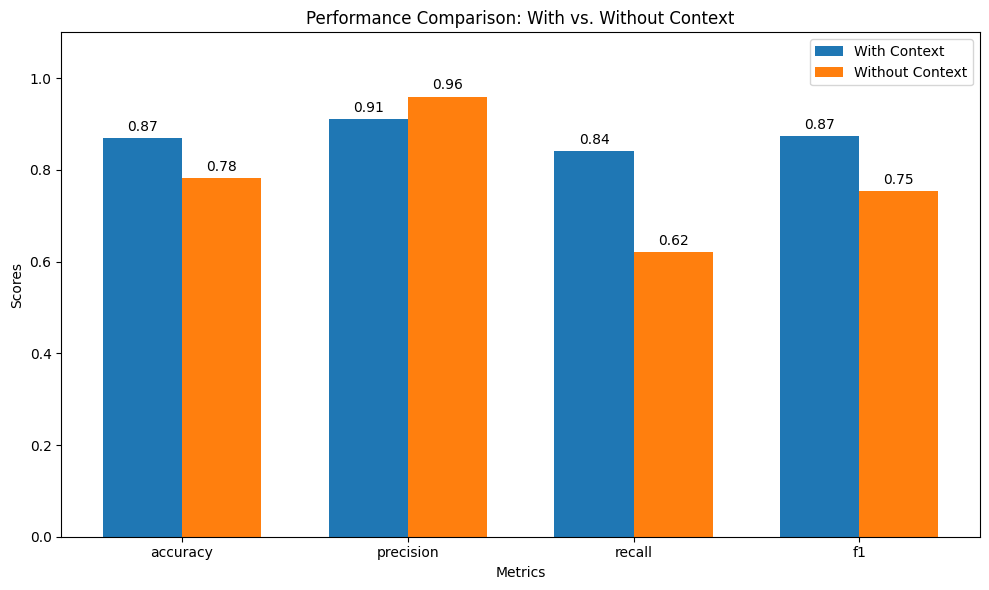

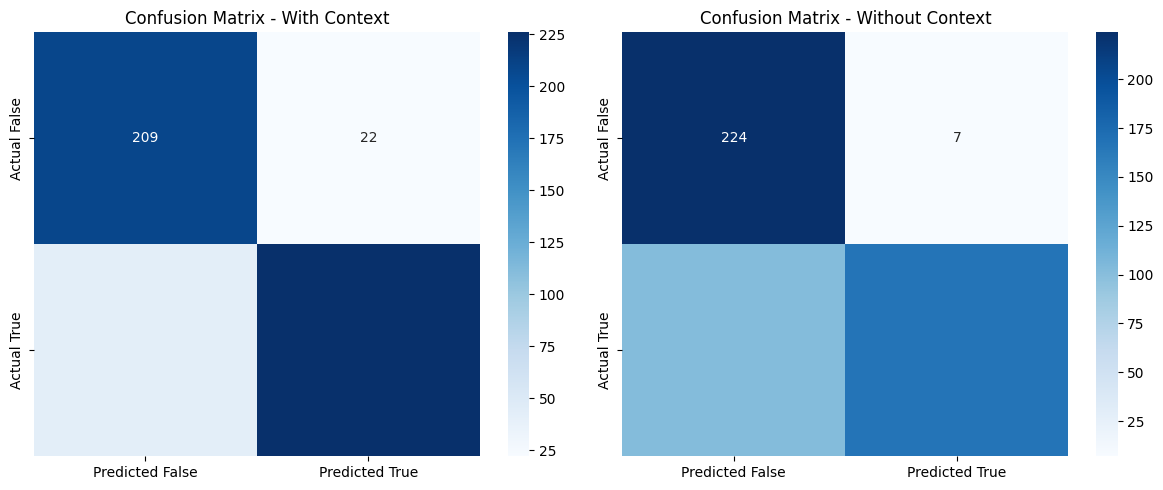

In [16]:
# Visualize metrics comparison
if with_context_metrics and without_context_metrics:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    with_context_values = [with_context_metrics[m] for m in metrics]
    without_context_values = [without_context_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, with_context_values, width, label='With Context')
    rects2 = ax.bar(x + width/2, without_context_values, width, label='Without Context')
    
    # Add labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison: With vs. Without Context')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    # Add value labels
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(rects1)
    add_labels(rects2)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # With context confusion matrix
    sns.heatmap(with_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    ax1.set_title('Confusion Matrix - With Context')
    
    # Without context confusion matrix
    sns.heatmap(without_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    ax2.set_title('Confusion Matrix - Without Context')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to visualize comparison")


Context Impact Summary:
Neutral: 361 questions (72.2%)
Positive: 74 questions (14.8%)
No Help: 35 questions (7.0%)
Negative: 30 questions (6.0%)


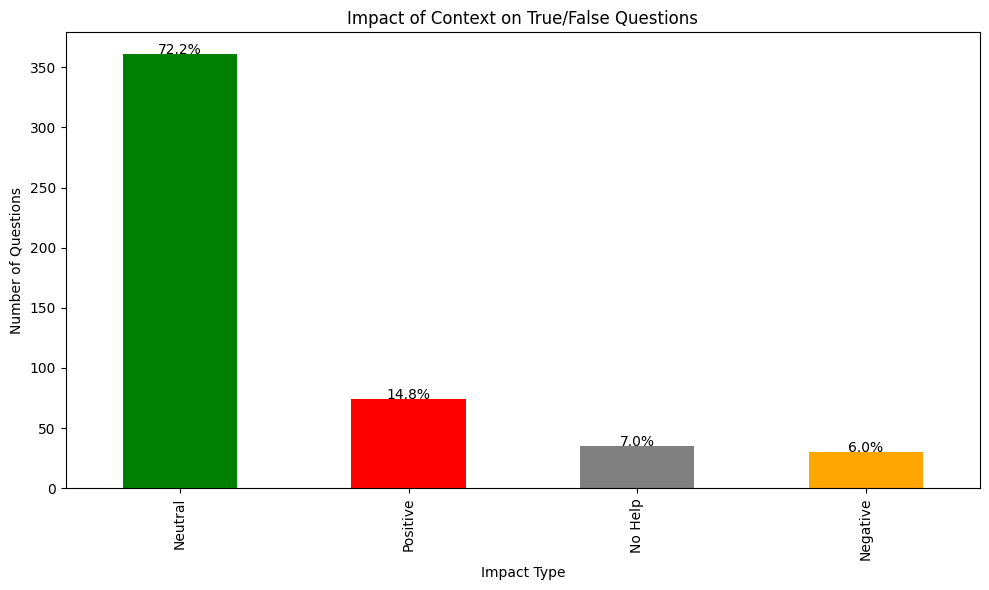

In [17]:
# Analyze the impact of context on each question
df['context_impact'] = None

for i, row in df.iterrows():
    # Skip if either prediction is None
    if row['with_context_parsed'] is None or row['without_context_parsed'] is None:
        df.at[i, 'context_impact'] = 'Unknown'
        continue
        
    with_correct = row['with_context_parsed'] == row['answer']
    without_correct = row['without_context_parsed'] == row['answer']
    
    if with_correct and not without_correct:
        df.at[i, 'context_impact'] = 'Positive'
    elif not with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Negative'
    elif with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Neutral'
    else:  # both incorrect
        df.at[i, 'context_impact'] = 'No Help'

# Summarize context impact
impact_counts = df['context_impact'].value_counts()
print("\nContext Impact Summary:")
for impact, count in impact_counts.items():
    print(f"{impact}: {count} questions ({count/len(df)*100:.1f}%)")

# Visualize context impact
plt.figure(figsize=(10, 6))
ax = impact_counts.plot(kind='bar', color=['green', 'red', 'gray', 'orange'])
plt.title('Impact of Context on True/False Questions')
plt.xlabel('Impact Type')
plt.ylabel('Number of Questions')

# Add percentages on top of bars
for i, v in enumerate(impact_counts):
    ax.text(i, v + 0.1, f"{v/len(df)*100:.1f}%", ha='center')

plt.tight_layout()
plt.show()

In [18]:
# Generate a summary report
print("\n" + "=" * 80)
print("EVALUATION SUMMARY REPORT")
print("=" * 80)
print(f"Total Questions: {len(df)}")
print(f"True Answers: {sum(df['answer'])}")
print(f"False Answers: {len(df) - sum(df['answer'])}")
print("\nPerformance Summary:")

if with_context_metrics and without_context_metrics:
    print(f"With Context Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy']*100:.1f}%)")
    print(f"Without Context Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy']*100:.1f}%)")
    
    # Determine if context helped overall
    if with_context_metrics['accuracy'] > without_context_metrics['accuracy']:
        diff = with_context_metrics['accuracy'] - without_context_metrics['accuracy']
        print(f"\nContext improved accuracy by {diff:.2f} ({diff*100:.1f}%)")
    elif with_context_metrics['accuracy'] < without_context_metrics['accuracy']:
        diff = without_context_metrics['accuracy'] - with_context_metrics['accuracy']
        print(f"\nContext decreased accuracy by {diff:.2f} ({diff*100:.1f}%)")
    else:
        print("\nContext had no overall impact on accuracy")

# List questions where context helped
helped_questions = df[df['context_impact'] == 'Positive']
if not helped_questions.empty:
    print("\nQuestions where context helped:")
    for i, row in helped_questions.iterrows():
        print(f"- {row['question']}")

# List questions where context was misleading
misled_questions = df[df['context_impact'] == 'Negative']
if not misled_questions.empty:
    print("\nQuestions where context was misleading:")
    for i, row in misled_questions.iterrows():
        print(f"- {row['question']}")

print("\nConclusions:")
print("1. Context retrieval" + (" improved " if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0) else " did not improve ") + "overall accuracy for true/false questions.")
print(f"2. {impact_counts.get('Positive', 0)} questions benefited from context, while {impact_counts.get('Negative', 0)} questions were negatively affected.")
print("3. Recommendations:")
print("   - " + ("Continue using RAG for true/false questions" if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0) else "Improve context retrieval or consider limiting RAG for true/false questions"))
print("   - Consider a hybrid approach that evaluates context quality before deciding whether to use it")
print("   - Expand the evaluation dataset to include more diverse true/false questions")


EVALUATION SUMMARY REPORT
Total Questions: 500
True Answers: 269
False Answers: 231

Performance Summary:
With Context Accuracy: 0.87 (87.0%)
Without Context Accuracy: 0.78 (78.2%)

Context improved accuracy by 0.09 (8.8%)

Questions where context helped:
- Is family history a risk factor for developing AMD?
- Does the Amsler grid help detect AMD symptoms?
- Does AMD affect color perception?
- Does wet AMD involve fluid leakage under the retina?
- Is AMD more prevalent in women than men?
- Is AMD linked to high cholesterol levels?
- Can AMD cause straight lines to appear wavy?
- Is AMD linked to UV light exposure?
- Can a dilated eye exam diagnose AMD?
- Does AMD affect the ability to recognize faces?
- Does AMD affect the central vision?
- Does wet AMD involve choroidal neovascularization?
- Is high cholesterol a risk factor for AMD?
- Can a dilated eye exam detect AMD?
- Does AMD affect driving ability?
- Does wet AMD cause hemorrhages under the retina?
- Can regular eye exams detec